**Import the libraries we'll use**

In [ ]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

#plots
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

#tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from tensorflow.keras.layers import BatchNormalization
from keras import metrics
from keras import utils

!pip install visualkeras
import visualkeras
from tensorflow.keras.utils import plot_model

%matplotlib inline

#Import CIFAR-10, CIFAR-100 Classification
from keras.datasets import cifar10, cifar100

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 kB 6.6 MB/s eta 0:00:00


**Check Runtime Resources**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 17 01:50:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    42W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


**CIFAR-10: Import and pre-process data**

In [ ]:
# load training and testing datasets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()  # or cifar100.load_data()

170498071/170498071 [==============================] - 4s 0us/step


x_train shape:  (50000, 32, 32, 3)
y_train shape:  (50000, 1)
x_test shape:  (10000, 32, 32, 3)
y_test shape:  (10000, 1)


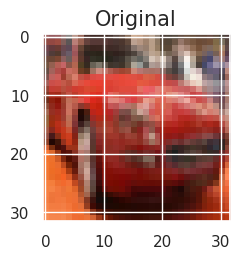

(50000, 32, 32, 3)


In [ ]:
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)

print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)


fig = plt.figure(figsize=(14, 12))
image = x_train[5]

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);

plt.show()


print(x_train.shape)


 **RESIZE to 64x64**

x_train shape:  (50000, 64, 64, 3)
y_train shape:  (50000, 1)
x_test shape:  (10000, 64, 64, 3)
y_test shape:  (10000, 1)


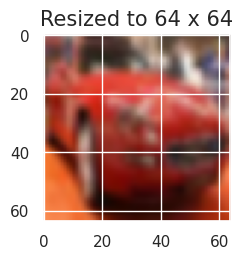

(50000, 64, 64, 3)


In [ ]:
IMAGE_SIZE = (64,64)
x_train = tf.image.resize(x_train, size=IMAGE_SIZE)
x_test = tf.image.resize(x_test, size=IMAGE_SIZE)
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)


fig = plt.figure(figsize=(14, 12))
image = x_train[5]

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Resized to 64 x 64', size=15);
plt.show()
print(x_train.shape)

In [ ]:

# covert to RGB
x_train = x_train/255.0
x_test = x_test/255.0


label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


 **Increase Brightness and Contrast**

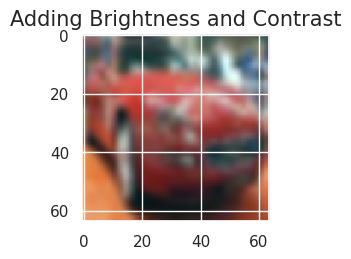

(50000, 64, 64, 3)


In [ ]:
CONTRAST_FACTOR = 2
DELTA = 0.3
# adjust brightness
x_train_augm = tf.image.adjust_brightness(x_train, delta=DELTA)

# adjust contrast
x_train_augm = tf.image.adjust_contrast(x_train, contrast_factor=CONTRAST_FACTOR)

#####Plotting image after adjusting brightness and contrast ######
fig = plt.figure(figsize=(14, 12))
image = x_train_augm[5]

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Adding Brightness and Contrast', size=15);
plt.show()
print(x_train.shape)
##############################################################

# random flip
x_train_augm = tf.image.random_flip_left_right(x_train_augm)

 **Data Augmentation**

In [ ]:
 # concatenate original X_train and augmented X_train data
x_train = tf.concat([x_train, x_train_augm],axis=0)

# concatenate y_train (note the label is preserved)
y_train_augm = y_train
y_train = tf.concat([y_train, y_train_augm],axis=0)

In [ ]:
# shuffle X_train and y_train, i.e., shuffle two tensors in the same order
shuffle = tf.random.shuffle(tf.range(tf.shape(x_train)[0], dtype=tf.int32))
X_train = tf.gather(x_train, shuffle)
y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array

###NOTE: FINAL TRAINING DATA SET IS STORED IN VARIABLE X_TRAIN

#### **Build CNN Model 3 With Batch Normalization**

In [ ]:
def build_cnn_model_3(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='Adam',
                learning_rate=0.1):
  """Build a neural network model using Keras.

  Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  model = keras.Sequential()

  model.add(keras.layers.Conv2D(filters = 64, kernel_size=(5,5), strides = (1,1), input_shape = (64,64,3), activation=activation, padding='same'))
  model.add(BatchNormalization())  
  model.add(keras.layers.Conv2D(filters = 64, kernel_size=(5,5), strides = (1,1), input_shape = (64,64,3), activation=activation, padding='same'))
  model.add(BatchNormalization())
  model.add(keras.layers.MaxPool2D(pool_size = (2,2)))
  model.add(tf.keras.layers.Dropout(rate=0.4)) # adjust dropout layer

  model.add(keras.layers.Conv2D(filters = 128, kernel_size=(5,5), strides = (1,1), input_shape = (64,64,3), activation=activation, padding='same'))
  model.add(BatchNormalization())  
  model.add(keras.layers.Conv2D(filters = 128, kernel_size=(5,5), strides = (1,1), input_shape = (64,64,3), activation=activation, padding='same'))
  model.add(BatchNormalization())
  model.add(keras.layers.MaxPool2D(pool_size = (2,2)))
  model.add(tf.keras.layers.Dropout(rate=0.4)) # adjust dropout layer

  model.add(keras.layers.Conv2D(filters = 256, kernel_size=(5,5), strides = (1,1), input_shape = (64,64,3), activation=activation, padding='same'))
  model.add(BatchNormalization())  
  model.add(keras.layers.Conv2D(filters = 256, kernel_size=(5,5), strides = (1,1), input_shape = (64,64,3), activation=activation, padding='same'))
  model.add(BatchNormalization())
  model.add(keras.layers.MaxPool2D(pool_size = (2,2)))
  model.add(tf.keras.layers.Dropout(rate=0.4)) # adjust dropout layer

  model.add(keras.layers.Flatten())
  for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(units=hidden_layer_size,
                                    activation = activation)) #use this for hidden layers
  
  model.add(tf.keras.layers.Dropout(rate=0.5)) # add dropout layer

  model.add(keras.layers.Dense(
      units=n_classes,
      activation="softmax")) #use "softmax" for active layers
  
  model.compile(loss = 'sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

#### **Apply Preprocessed images to model**

In [ ]:
model = build_cnn_model_3(len(label_names), learning_rate=0.01, hidden_layer_sizes=[1024, 1024])

history = model.fit(
  x = X_train,
  y = y_train,
  epochs=20, #can we train a bit longer
  batch_size=64,
  validation_split=0.1,
  verbose=1)

display(pd.DataFrame(history.history))
print(model.summary())

Epoch 1/20
1407/1407 [==============================] - 49s 21ms/step - loss: 1.9003 - accuracy: 0.3859 - val_loss: 1.6976 - val_accuracy: 0.4536
Epoch 2/20
1407/1407 [==============================] - 29s 20ms/step - loss: 1.1074 - accuracy: 0.6201 - val_loss: 1.0506 - val_accuracy: 0.6527
Epoch 3/20
1407/1407 [==============================] - 28s 20ms/step - loss: 0.8237 - accuracy: 0.7219 - val_loss: 0.7093 - val_accuracy: 0.7592
Epoch 4/20
1407/1407 [==============================] - 29s 20ms/step - loss: 0.6501 - accuracy: 0.7845 - val_loss: 0.6379 - val_accuracy: 0.7939
Epoch 5/20
1407/1407 [==============================] - 29s 20ms/step - loss: 0.5324 - accuracy: 0.8241 - val_loss: 0.6331 - val_accuracy: 0.7916
Epoch 6/20
1407/1407 [==============================] - 29s 20ms/step - loss: 0.4342 - accuracy: 0.8561 - val_loss: 0.5056 - val_accuracy: 0.8317
Epoch 7/20
1407/1407 [==============================] - 29s 20ms/step - loss: 0.3615 - accuracy: 0.8803 - val_loss: 0.4548 -

,loss,accuracy,val_loss,val_accuracy
0,1.900262,0.385856,1.697594,0.4536
1,1.107390,0.620078,1.050582,0.6527
2,0.823731,0.721867,0.709329,0.7592
3,0.650065,0.784522,0.637924,0.7939
4,0.532369,0.824111,0.633091,0.7916
5,0.434190,0.856111,0.505643,0.8317
6,0.361533,0.880311,0.454803,0.8622
7,0.301720,0.902267,0.428690,0.8739
8,0.257585,0.917822,0.412807,0.8854
9,0.212324,0.933467,0.428960,0.8814


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                        

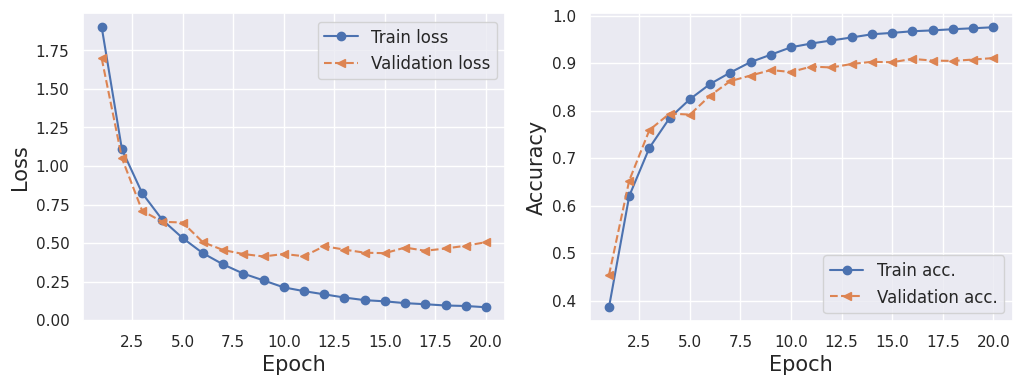

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

 **Calculate Testing Accuracy**

In [ ]:
test_results = model.evaluate(x_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))


313/313 [==============================] - 2s 4ms/step - loss: 0.9463 - accuracy: 0.8341

Test Acc. 83.41%


 **Confusion Matrix**

In [ ]:
# Get labels by taking the argmax -- the index with the largest probability.
test_predictions = np.argmax(model.predict(x_test), axis=-1)
print(test_predictions)

313/313 [==============================] - 1s 3ms/step
[3 8 8 ... 5 1 7]


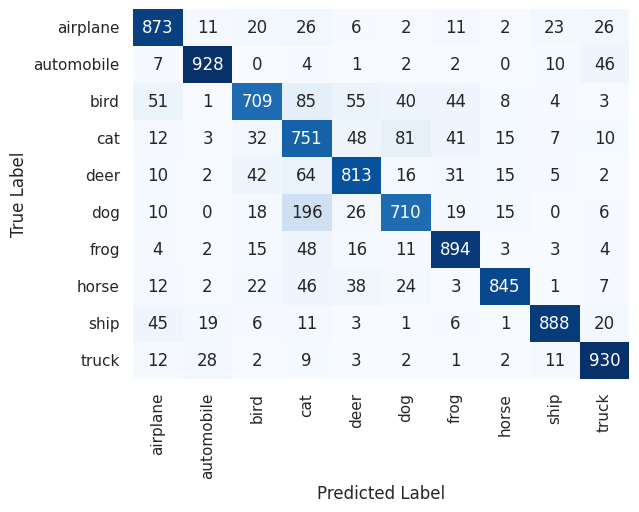

In [ ]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

 **Evaluate CNN Model Precision and Accuracy Metrics by Label**

In [ ]:
# Calculate Precision: TP / (TP+FP) ~ divide the true positives for each label by the sum down the columns (axis=0) 
for i in range(10):
    print(label_names[i], "\t", confusion_matrix[(i,i)]/tf.reduce_sum(confusion_matrix,0)[i])

airplane 	 tf.Tensor(0.8426640926640927, shape=(), dtype=float64)
automobile 	 tf.Tensor(0.9317269076305221, shape=(), dtype=float64)
bird 	 tf.Tensor(0.8187066974595842, shape=(), dtype=float64)
cat 	 tf.Tensor(0.6056451612903225, shape=(), dtype=float64)
deer 	 tf.Tensor(0.8057482656095144, shape=(), dtype=float64)
dog 	 tf.Tensor(0.7986501687289089, shape=(), dtype=float64)
frog 	 tf.Tensor(0.8498098859315589, shape=(), dtype=float64)
horse 	 tf.Tensor(0.9326710816777042, shape=(), dtype=float64)
ship 	 tf.Tensor(0.9327731092436975, shape=(), dtype=float64)
truck 	 tf.Tensor(0.8823529411764706, shape=(), dtype=float64)


**Animal Vs Non-Animal Precision**

In [ ]:
# Define the animal and non-animal classes
animal_indices = [2, 3, 4, 5, 6, 7]  # Indices of animal classes in the confusion matrix
non_animal_indices = [0, 1, 8, 9]  # Indices of non-animal classes in the confusion matrix

# Extract animal and non-animal confusion matrices
animal_confusion_matrix = tf.gather(confusion_matrix, indices=animal_indices, axis=0)
animal_confusion_matrix = tf.gather(animal_confusion_matrix, indices=animal_indices, axis=1)

non_animal_confusion_matrix = tf.gather(confusion_matrix, indices=non_animal_indices, axis=0)
non_animal_confusion_matrix = tf.gather(non_animal_confusion_matrix, indices=non_animal_indices, axis=1)

# Convert the confusion matrices to NumPy arrays
animal_confusion_matrix_np = animal_confusion_matrix.numpy()
non_animal_confusion_matrix_np = non_animal_confusion_matrix.numpy()

# Calculate true positives and false positives for animal and non-animal classes
animal_true_positives = np.diag(animal_confusion_matrix_np)
animal_false_positives = np.sum(animal_confusion_matrix_np, axis=0) - animal_true_positives

non_animal_true_positives = np.diag(non_animal_confusion_matrix_np)
non_animal_false_positives = np.sum(non_animal_confusion_matrix_np, axis=0) - non_animal_true_positives

# Calculate precision for animal and non-animal classes
animal_precision = np.sum(animal_true_positives) / (np.sum(animal_true_positives) + np.sum(animal_false_positives))
non_animal_precision = np.sum(non_animal_true_positives) / (np.sum(non_animal_true_positives) + np.sum(non_animal_false_positives))

print("Animal Precision:", animal_precision)
print("Non-Animal Precision:", non_animal_precision)

Animal Precision: 0.8087001198835417
Non-Animal Precision: 0.9334537013154501


# **Apply Image Pre Processing to VGG**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.utils.np_utils import to_categorical

In [ ]:
# Initialize our vgg16 pre-trained model with imagenet weights
vgg16_model = VGG16(weights='imagenet',
                    include_top=False, 
                    classes=10,
                    input_shape=(64,64,3)# input: 32x32 images with 3 channels -> (32, 32, 3) tensors.
                   )

#Define the sequential model and add th VGG's layers to it
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

# Adding hidden and output layer to our model

from tensorflow.keras.layers import Dense, Flatten, Dropout
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0         
                                                       

In [ ]:
# Build validation datasets


y_train_ohe = to_categorical(y_train, num_classes = 10)
y_test_ohe = to_categorical(y_test, num_classes = 10)

# Build validation datasets
x_val = X_train[40000:]
y_val = y_train_ohe[40000:]
print(f"x_val shape {x_val.shape}")
print(f"y_val shape {y_val.shape}")

x_val shape (60000, 64, 64, 3)
y_val shape (60000, 10)


In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler

# initiate SGD optimizer
sgd = optimizers.SGD(learning_rate=0.001, momentum=0.9)

# For a multi-class classification problem
model.compile(loss='categorical_crossentropy',optimizer= sgd,metrics=['accuracy'])

# initialize the number of epochs and batch size
EPOCHS = 20
BS = 128

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20, 
    zoom_range=0.15, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.15,
    horizontal_flip=True, 
    fill_mode="nearest")
 
# train the model
history = model.fit(
    aug.flow(X_train,y_train_ohe, batch_size=BS),
    validation_data=(x_val,y_val),
    epochs=EPOCHS)

#show output of model
display(pd.DataFrame(history.history))
print(model.summary())

Epoch 1/20
782/782 [==============================] - 128s 158ms/step - loss: 0.9983 - accuracy: 0.6483 - val_loss: 0.4145 - val_accuracy: 0.8586
Epoch 2/20
782/782 [==============================] - 120s 153ms/step - loss: 0.5224 - accuracy: 0.8231 - val_loss: 0.3466 - val_accuracy: 0.8820
Epoch 3/20
782/782 [==============================] - 120s 154ms/step - loss: 0.4172 - accuracy: 0.8586 - val_loss: 0.2512 - val_accuracy: 0.9135
Epoch 4/20
782/782 [==============================] - 120s 153ms/step - loss: 0.3493 - accuracy: 0.8812 - val_loss: 0.2047 - val_accuracy: 0.9302
Epoch 5/20
782/782 [==============================] - 121s 154ms/step - loss: 0.3087 - accuracy: 0.8952 - val_loss: 0.1963 - val_accuracy: 0.9316
Epoch 6/20
782/782 [==============================] - 120s 153ms/step - loss: 0.2712 - accuracy: 0.9077 - val_loss: 0.1582 - val_accuracy: 0.9448
Epoch 7/20
782/782 [==============================] - 120s 154ms/step - loss: 0.2448 - accuracy: 0.9173 - val_loss: 0.1304 -

,loss,accuracy,val_loss,val_accuracy
0,0.998281,0.64831,0.414541,0.858633
1,0.522426,0.82308,0.346606,0.881950
2,0.417202,0.85863,0.251235,0.913450
3,0.349322,0.88121,0.204742,0.930217
4,0.308703,0.89520,0.196307,0.931567
5,0.271211,0.90768,0.158168,0.944750
6,0.244756,0.91726,0.130442,0.955000
7,0.223542,0.92383,0.117499,0.959817
8,0.205367,0.93001,0.110951,0.961217
9,0.185577,0.93645,0.113124,0.959600


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 16, 16, 256)      

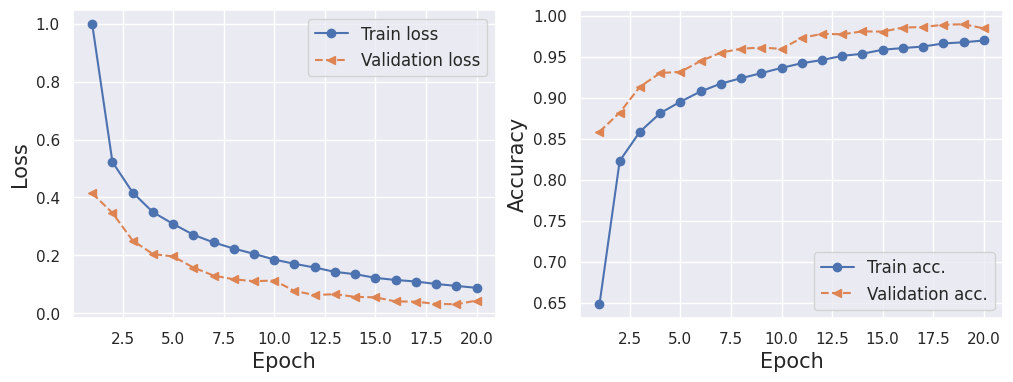

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [ ]:
test_results = model.evaluate(x_test, y_test_ohe)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

313/313 [==============================] - 2s 5ms/step - loss: 0.2582 - accuracy: 0.9298

Test Acc. 92.98%


In [ ]:
# Get labels by taking the argmax -- the index with the largest probability.
test_predictions = np.argmax(model.predict(x_test), axis=-1)
print(test_predictions)

313/313 [==============================] - 1s 4ms/step
[3 8 8 ... 5 1 7]


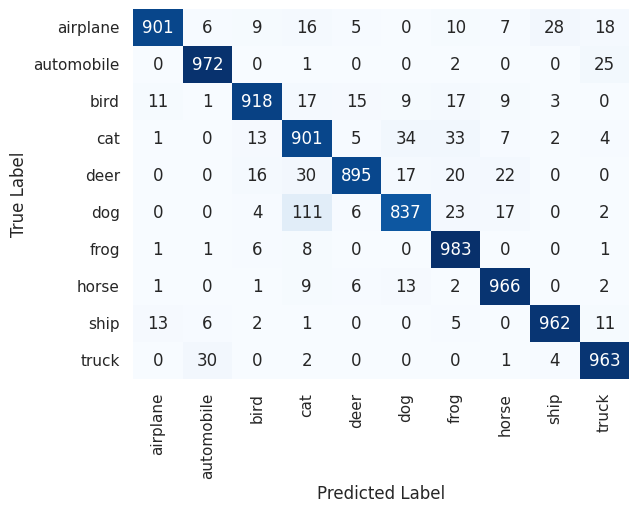

In [ ]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [ ]:
# Define the animal and non-animal classes
animal_indices = [2, 3, 4, 5, 6, 7]  # Indices of animal classes in the confusion matrix
non_animal_indices = [0, 1, 8, 9]  # Indices of non-animal classes in the confusion matrix

# Extract animal and non-animal confusion matrices
animal_confusion_matrix = tf.gather(confusion_matrix, indices=animal_indices, axis=0)
animal_confusion_matrix = tf.gather(animal_confusion_matrix, indices=animal_indices, axis=1)

non_animal_confusion_matrix = tf.gather(confusion_matrix, indices=non_animal_indices, axis=0)
non_animal_confusion_matrix = tf.gather(non_animal_confusion_matrix, indices=non_animal_indices, axis=1)

# Convert the confusion matrices to NumPy arrays
animal_confusion_matrix_np = animal_confusion_matrix.numpy()
non_animal_confusion_matrix_np = non_animal_confusion_matrix.numpy()

# Calculate true positives and false positives for animal and non-animal classes
animal_true_positives = np.diag(animal_confusion_matrix_np)
animal_false_positives = np.sum(animal_confusion_matrix_np, axis=0) - animal_true_positives

non_animal_true_positives = np.diag(non_animal_confusion_matrix_np)
non_animal_false_positives = np.sum(non_animal_confusion_matrix_np, axis=0) - non_animal_true_positives

# Calculate precision for animal and non-animal classes
animal_precision = np.sum(animal_true_positives) / (np.sum(animal_true_positives) + np.sum(animal_false_positives))
non_animal_precision = np.sum(non_animal_true_positives) / (np.sum(non_animal_true_positives) + np.sum(non_animal_false_positives))

print("Animal Precision:", animal_precision)
print("Non-Animal Precision:", non_animal_precision)

Animal Precision: 0.9212730318257957
Non-Animal Precision: 0.9642041127189642


## **Conclusion And Test Results**

*Written answer*:

| Model | Resize Image  | Validation accuracy |  Training accuracy   |  Testing accuracy   | brightness (delta) |  contrast factor | flip_on_train  | Animal Precision | Non Animal Precision
|:-:     |:-:            |:-:                  |:-:       |:-:     |:-:       |:-:                     |:-:      |:-:       |:-:                  |
| CNN3   |64x64          | 0.90               | 0.97      | 84.40%           | 0.3                | 2                | yes  | 0.8087 | 0.9334
| CNN3   |64x64          | 0.91               | 0.97      | 83.20%           | 0.1                | 2                | yes            |
| CNN3   |64x64          | 0.90               | 0.96       | 83.01%         | 0.3                | 3                | yes 
| CNN3   |64x64          | 0.97               | 0.98      | 82.30%           | 0.3                | 2                | no            |
| VGG   |64x64          | 0.99               | 0.96       | 93.85%         | 0.3                | 2               | yes            | 0.9212 | 0.9642
